# Explore here

It's recommended to use this notebook for exploration purposes.

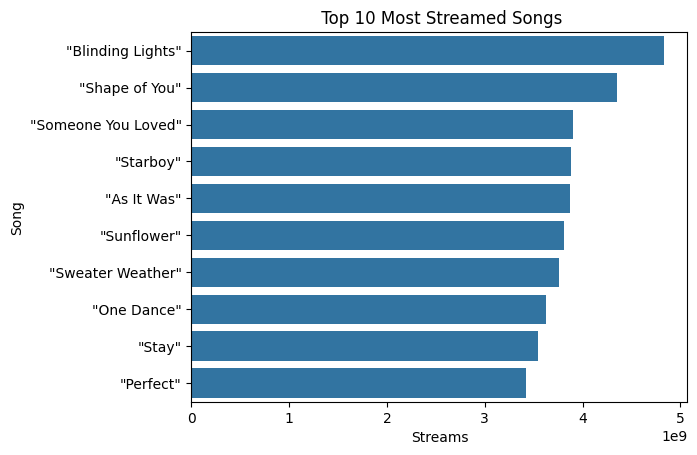

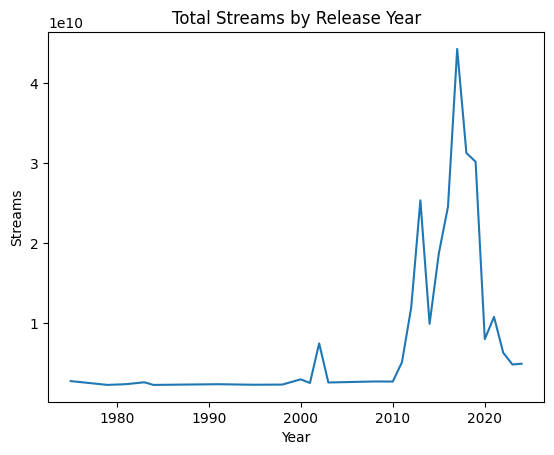

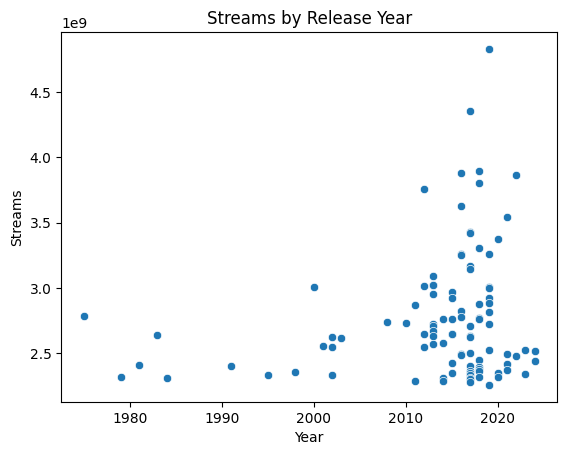

,Rank,Song,Artist,Streams,Release_date,Ref.,Year
0,1,"""Blinding Lights""",The Weeknd,4830000000.0,2019-11-29,[2],2019
1,2,"""Shape of You""",Ed Sheeran,4351000000.0,2017-01-06,[3],2017
2,3,"""Someone You Loved""",Lewis Capaldi,3897000000.0,2018-11-08,[4],2018
3,4,"""Starboy""",The Weeknd and Daft Punk,3882000000.0,2016-09-21,[5],2016
4,5,"""As It Was""",Harry Styles,3868000000.0,2022-04-01,[6],2022
...,...,...,...,...,...,...,...
95,96,"""Too Good at Goodbyes""",Sam Smith,2299000000.0,2017-09-08,[97],2017
96,97,"""Stay with Me""",Sam Smith,2290000000.0,2014-04-14,[98],2014
97,98,"""Someone Like You""",Adele,2287000000.0,2011-01-24,[99],2011
98,99,"""Havana""",Camila Cabello and Young Thug,2278000000.0,2017-08-03,[100],2017


In [28]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

resource_url = "https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records"

response = requests.get(resource_url, time.sleep(10))
if response:
    soup = BeautifulSoup(response.text, 'html')
    soup

# Get the data from Wikipedia using pandas.
data = pd.read_html(resource_url)
# Transform into a DF to access each column/row individually
df = data[0]
# Remove 'as of May...' since it bothers the code below
df = df[~df['Rank'].astype(str).str.contains("As of")]
# Remove unwanted characters from the respective columns
df.loc[:, 'Streams (billions)'] = (df['Streams (billions)'].astype(str).str.replace('$', '').str.replace('B','').astype(float)*1000000000)
# Remove NaN values
df.dropna()

# Rename column for SQLite 
df = df.copy()
df.rename(columns={"Artist(s)": "Artist"}, inplace=True)
df.rename(columns={"Streams (billions)": "Streams"}, inplace=True)
df.rename(columns={"Release date": "Release_date"}, inplace=True)

# Connect to SQLite 
con = sqlite3.connect('test.db')
cursor = con.cursor()

# We create the table

cursor.execute('''
    CREATE TABLE IF NOT EXISTS spotify_songs (
               Rank INTEGER,
               Song TEXT,
               Artist TEXT,
               Streams REAL,
               Release_date TEXT
    )
''')

# We insert the data 

for index, row in df.iterrows():
    cursor.execute('''
        INSERT INTO spotify_songs (Rank, Song, Artist, Streams, Release_date)
        VALUES (?, ?, ?, ?, ?)
''', (
    row['Rank'],
    row['Song'],
    row['Artist'],
    row['Streams'],
    row['Release_date']
))
    
# Finish
con.commit()
con.close()

# Reconnecting to the database

con = sqlite3.connect('test.db')
cursor = con.cursor()

# Visualizing the data

# 1. Bar Plot: 10 Most Streamed Songs

top_songs = df.sort_values('Streams', ascending=False).head(10)
sns.barplot(data=top_songs, x='Streams', y='Song')
plt.title(' Top 10 Most Streamed Songs')
plt.xlabel('Streams')
plt.ylabel('Song')
plt.show()


# 2. Line PLot: Streams by Release Year
df['Release_date'] = pd.to_datetime(df['Release_date'], errors='coerce')
df['Year'] = df['Release_date'].dt.year
streams_by_year = df.groupby('Year')['Streams'].sum().reset_index()

sns.lineplot(data=streams_by_year, x='Year', y='Streams')
plt.title('Total Streams by Release Year')
plt.ylabel('Streams')
plt.show()

# 3. Scatter Plot: Streams vs Release Year

sns.scatterplot(data=df, x='Year', y='Streams')
plt.title('Streams by Release Year')
plt.show()

display(df)